In [24]:
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import numpy  as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
import pickle as pk

### Loading cleaned data 

In [11]:
raw = pd.read_csv("../Data/traindata_full_dummified.csv")
raw_test = pd.read_csv("../Data/testdata_full_dummified.csv")
print(raw.shape)
print(raw_test.shape)

(1458, 241)
(1459, 240)


### Dropping outliers and getting data ready for Lasso

In [12]:
def find_outliers(df,col):
    mean = np.mean(df[col], axis=0)
    sd = np.std(df[col], axis=0)
    gap=mean-4*sd
    gap2=mean+4*sd
    outliers = df[ (df[col] > gap2) | (df[col]< gap)].index
    return outliers


In [13]:
miscval=list(find_outliers(raw, 'MiscVal'))
lotarea=list(find_outliers(raw, 'LotArea'))
#grlivarea= list(find_outliers(raw, 'GrLivArea'))
droplist=miscval+lotarea#+grlivarea
raw.drop(droplist,axis=0, inplace=True)

In [14]:
sale_price = raw['LogSalePrice']
raw = raw.drop(['LogSalePrice','Id'],axis=1)
X = raw.copy()
Y = sale_price.copy()
test_IDs = pd.DataFrame(raw_test['Id'])
raw_test = raw_test.drop('Id', axis = 1)

In [15]:
print(raw.shape)
print(X.shape)
print(raw_test.shape)
print(Y.shape)

(1444, 239)
(1444, 239)
(1459, 239)
(1444,)


### Checking for best alpha

In [32]:
lasso = Lasso(normalize = True, max_iter = 10000)

In [81]:
alphas = np.logspace(-8, -2, 50)
lasso.set_params(normalize=True)
coefs  = []
scores = []
for alpha in alphas:
        lasso.set_params(alpha=alpha)
        lasso.fit(X, Y)  
        coefs.append(lasso.coef_)
        scores.append(lasso.score(X, Y))
coefs = pd.DataFrame(coefs, index = alphas, columns = X.columns)  

Text(0, 0.5, 'slope values')

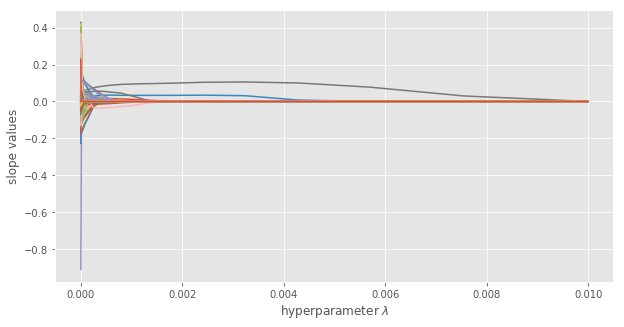

In [82]:
plt.rcParams['figure.figsize'] = (10,5)
for name in coefs.columns:
    plt.plot(coefs.index, coefs[name], label=name)   
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'slope values')


In [92]:
alphas = np.logspace(-5, -2, 50)
lasso.set_params(normalize=True)
coefs  = []
scores = []
for alpha in alphas:
        lasso.set_params(alpha=alpha)
        lasso.fit(X, Y)  
        coefs.append(lasso.coef_)
        scores.append(lasso.score(X, Y))
coefs = pd.DataFrame(coefs, index = alphas, columns = X.columns)  

Text(0, 0.5, 'slope values')

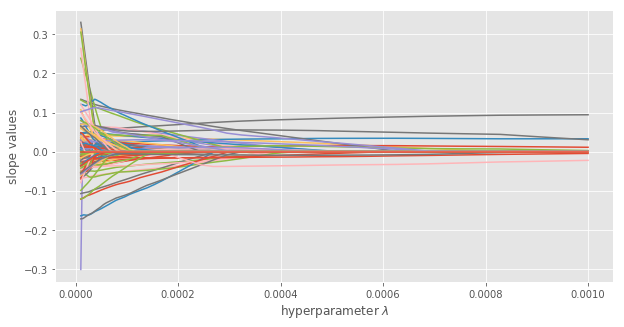

In [91]:
plt.rcParams['figure.figsize'] = (10,5)
for name in coefs.columns:
    plt.plot(coefs.index, coefs[name], label=name)   
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'slope values')


### Running model with train test split

In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.25, random_state= 0)

In [34]:
alphas = np.logspace(-5, -2, 50)
tuned_parameters = [{'alpha': alphas}]
n_folds = 6
cv = KFold(n_splits=n_folds, shuffle=True)
tune_lasso = GridSearchCV(lasso, tuned_parameters, 
                          cv=cv, refit=True, return_train_score = True, 
                          scoring = 'neg_mean_squared_error')
tune_lasso.fit(train_X,train_Y)
print("Tune best score: ",tune_lasso.best_params_)
print("Tune best RMSE: ",sqrt(np.min((-tune_lasso.cv_results_['mean_test_score']))))

Tune best score:  {'alpha': 7.196856730011529e-05}
Tune best RMSE:  0.11387800291806167


In [37]:
lasso.set_params(alpha = tune_lasso.best_params_['alpha'], normalize = True, max_iter = 10000)
lasso.fit(train_X, train_Y)
print("Train/test score",lasso.score(train_X, train_Y))
print("Train/test RMSE", sqrt(mean_squared_error(test_Y, lasso.predict(test_X))))

Train/test score 0.9424148978592172
Train/test RMSE 0.12578004077262986


### Running Lasso on full data set

In [42]:
lasso = Lasso( normalize = True, max_iter = 10000)

In [93]:
alphas_lasso = np.logspace(-5, -4, 50)
tuned_parameters = [{'alpha': alphas_lasso}]
n_folds = 6
cv = KFold(n_splits=n_folds, shuffle=True)
tune_lasso = GridSearchCV(lasso, tuned_parameters, 
                          cv=cv, refit=True, return_train_score = True, 
                          scoring = 'neg_mean_squared_error')
tune_lasso.fit(X,Y)
print("Tune best score: ",tune_lasso.best_params_)
print("Tune best RMSE: ",sqrt(np.min(-tune_lasso.cv_results_['mean_test_score'])))

Tune best score:  {'alpha': 0.0001}
Tune best RMSE:  0.11599276162744315


In [94]:
lasso.set_params(alpha = tune_lasso.best_params_['alpha'], normalize = True, max_iter = 10000)
lasso.fit(X, Y)
print("Full set score",lasso.score(X, Y))
print("Full set RMSE", sqrt(mean_squared_error(Y, lasso.predict(X))))


Full set score 0.9298162189482736
Full set RMSE 0.10509994470485085


### Running for loop to get best alphas with narrower range

In [63]:
tune_scores = []
tune_alphas = []
scores = []
rmse = []

for i in range(10):
    lasso = Lasso(normalize = True, max_iter = 10000)
    lasso_tune_nest = GridSearchCV(lasso, [{'alpha': np.logspace(-5, -3, 50)}], 
                          cv=KFold(n_splits=5, shuffle=True), refit=True, return_train_score = True, 
                          scoring = 'neg_mean_squared_error')
    lasso_tune_nest.fit(X, Y)
    tune_scores.append(np.min(-lasso_tune_nest.cv_results_['mean_test_score']))
    tune_alphas.append(lasso_tune_nest.best_params_['alpha'])
    print("Tune best RMSE: ",sqrt(np.min(-tune_lasso.cv_results_['mean_test_score'])))
    lasso.set_params(alpha = lasso_tune_nest.best_params_['alpha'], normalize = True, max_iter = 10000)
    lasso.fit(X, Y)
    scores.append(lasso.score(X, Y))
    rmse.append(sqrt(mean_squared_error(Y, lasso.predict(X))))
    print("Full set score",lasso.score(X, Y))
    print("Full set RMSE", sqrt(mean_squared_error(Y, lasso.predict(X))))


Tune best RMSE:  0.11403385323997707
Full set score 0.9283278389896201
Full set RMSE 0.10620851983870329
Tune best RMSE:  0.11403385323997707
Full set score 0.9293353773757567
Full set RMSE 0.10545935936356189
Tune best RMSE:  0.11403385323997707
Full set score 0.9311802888231765
Full set RMSE 0.10407358853115056
Tune best RMSE:  0.11403385323997707
Full set score 0.9283278389896201
Full set RMSE 0.10620851983870329
Tune best RMSE:  0.11403385323997707
Full set score 0.9293353773757567
Full set RMSE 0.10545935936356189
Tune best RMSE:  0.11403385323997707
Full set score 0.9283278389896201
Full set RMSE 0.10620851983870329
Tune best RMSE:  0.11403385323997707
Full set score 0.930297861429223
Full set RMSE 0.10473869497069312
Tune best RMSE:  0.11403385323997707
Full set score 0.9293353773757567
Full set RMSE 0.10545935936356189
Tune best RMSE:  0.11403385323997707
Full set score 0.9293353773757567
Full set RMSE 0.10545935936356189
Tune best RMSE:  0.11403385323997707
Full set score 0.93

In [70]:
best_rmse,indx = min((v,i) for i,v in enumerate(rmse))
best_alpha = tune_alphas[indx]
print("best alpha:", best_alpha)
print("best rmse:", best_rmse)


best alpha: 6.55128556859551e-05
best rmse: 0.10197498092547111


In [67]:
lasso.set_params(alpha = best_alpha, normalize = True, max_iter = 10000)
lasso.fit(X, Y)



Lasso(alpha=6.55128556859551e-05, copy_X=True, fit_intercept=True,
   max_iter=10000, normalize=True, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

###  Saving model 

In [95]:
filename = 'finalized_model_best_lasso.sav'
pk.dump(lasso, open(filename, 'wb'))

### Predicting results and preparing for kaggle submission

In [96]:
predict_lasso = pd.DataFrame(np.exp(lasso.predict(raw_test)))
full_pred = pd.concat([test_IDs,predict_lasso], axis = 1)
full_pred.columns = ['Id', 'SalePrice']
full_pred.to_csv('results_lasso.csv', index = False)